## ***SIMULACIÓN***  
Métodos necesarios para la simulación del inventario

In [5]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

Inicialización de variables

In [6]:
x_1 = 70 #numero de unidades del producto 1
x_2 = 70 #numero de unidades del producto 2
T_simulacion = 5*24*30
#T_simulacion = 5*30*24 #tiempo transcurrido en la simulacion en horas
Tp = 7*24 #cada cuanto pide (cada semana)
lista = {'tc': 0,  # tiempo en el que ha llegado un cliente
         'tpc': 0, # tiempo en el que se ha comprado un pedido
         'tp': 0}  # tiempo en el que ha llegado un pedido
R = 0 #beneficio esperado
P1 = 1000 #numero de unidades max del producto 1
P2 = 1500 #numero de unidades max del producto 2
Nc = 0 #numero de clientes satisfechos
Nnc = 0 # numero de clientes no satisfechos
t0 = 0 # numero de tiempo que el intervalo esta a cero
C = 0 #coste total por pedidos
H = 0 #coste total por almacenamiento
lambda_poisson = 0.5
demanda = [1, 2, 3, 4] #posibles demandas del producto
probab_1 = [0.3, 0.4, 0.2, 0.1] #probabilidades de demanda del producto 1
probab_2 = [0.2, 0.2, 0.4, 0.2] #probabilidades de demanda del producto 2
r_1 = 2.5 #coste al publico del producto 1
r_2 = 3.5 #coste al publico del producto 2
h = 0.0002 #precio sumado por producto y unidad de tiempo
mu = 48 #tiempo de media que tarda un pedido
sigma = 3.5 #desviacion tipica de lo que tarda un pedido
K = 100 #coste fijo del proveedor
n_descuent_1 = 600 #unidades mayores a estas obtienen descuento en producto 1
p1_1 = 1 # precio si son menos de 600 uds del producto 1
p1_2 = 0.75 # precio si son mas de 600 uds del producto 1
n_descuent_2 = 800
p2_1 = 1.5
p2_2 = 1.25
L = 0 #lo que tarda en llegar el pedido desde que se compra
Lref = 48 #tiempo media de llegada del pedido
lim_penal = 3 #a partir de estas horas de retraso del pedido, penalizacion
penal = 0.0003 # la penalizacion en el precio si llega tarde/pronto 
t_real = 0
var_aux = 0 # instante en el que el almacen se vacia completamnete
ts = 0 #tiempo de simulacion

#Vectores para la representación gráfica de los niveles de inventario de los dos tipos de producto a lo largo del tiempo

tiempos_1 = [0]
niveles_1 = [70]
tiempos_2 = [0]
niveles_2 = [70]

# datos_grafica [producto 1 o 2] [tiempo (0) o nivel(1)] [i]  
datos_grafica = ["",
                 [[0],[70]], # tiempo y nivel producto 1
                 [[0],[70]]  # tiempo y nivel producto 2
                ]

Métodos para la simulación

In [7]:
def rutina_llegada_cliente(ts):
    global H, h, t_real, x_1, x_2, Nc, Nnc, var_aux, R, Y, y_1, y_2
    global r_1, r_2, var_aux, T_simulacion, tiempos_1, tiempos_2
    global niveles_1, niveles_2
  
    #Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Generamos demanda del cliente
    demanda_1 = np.random.choice(demanda, 1, p=probab_1)[0]
    demanda_2 = np.random.choice(demanda, 1, p=probab_2)[0]
  
    #Si hay suficiente almacenado, esta satisfecho
    if demanda_1<=x_1 and demanda_2<=x_2 :
        R += demanda_1*r_1 + demanda_2*r_2 #sube el beneficio
        x_1 -= demanda_1   #baja el inventario
        x_2 -= demanda_2
        Nc += 1 #cliente satisfecho
    #Si no hay suficiente almacenado de algun producto, no esta satisfecho
    else:
        Nnc += 1 #cliente no satisfecho
        if demanda_1 <= x_1:
            R += demanda_1*r_1 
            x_1 -= demanda_1
        elif demanda_2 <= x_2:
            R += demanda_2*r_2 
            x_2 -= demanda_2
    
    # Si se ha vaciado del todo (y antes no estaba vacio) guardamos el tiempo actual
    if x_2 == 0 and x_1 == 0 and var_aux == 0 :
        var_aux = t_real
    
    #Generamos el tiempo que tarda en llegar el siguiente cliente
    Y = stats.poisson.rvs(lambda_poisson, size=1)[0] 
  
    # si el cliente llega antes de acabar la simulacion, se simula
    if Y+t_real < T_simulacion:
        lista['tc'] = t_real+Y 

In [8]:
def rutina_llegada_pedido(ts):
    global H, K, h, t_real, C, t0, var_aux, x_1, x_2, y_1, y_2
    global p1_1, p1_2, p2_1, p2_1, penal, var_aux
    global tiempos_1, tiempos_2, niveles_1, niveles_2
  
    #Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Aumenta el nivel de inventario
    x_1 += y_1
    x_2 += y_2
  
    #Si son muchas unidades, descuento en el precio
    Ci_1 = K + y_1 * p1_1 if y_1<=n_descuent_1 else K + y_1 * p1_2
    Ci_2 = K + y_2 * p2_1 if y_2<=n_descuent_2 else K + y_2 * p2_2
  
    #Si llega pronto es mas caro, si llega tarde, es mas barato
    if L < Lref-lim_penal:
        C += (Ci_1 + Ci_2) * (1 + penal)
    elif L > Lref+lim_penal:
        C += (Ci_1 + Ci_2) * (1 - penal)
    else:
        C += Ci_1 + Ci_2
  
    #Ya no quedan productos por llegar
    y_1 = 0
    y_2 = 0
  
    # Si estaba vacio el invenario (se vacio en el instante var_aux),
    # aumenta el tiempo que ha estado vacio.
    if var_aux > 0:
        t0 += t_real - var_aux
        var_aux = 0

In [9]:
def rutina_compra_pedido(ts):
    global H, x_1, x_2, t_real, y_1, y_2, h, t_real
    global P1, P2, lista, T_simulacion

    # Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Cantidad a pedir es lo que falta para llenar el almacen
    y_1 = P1 - x_1
    y_2 = P2 - x_2

    #Generamos cuanto va a tardar en llegar el pedido
    L = np.random.normal(mu, sigma, 1)[0]

    # actualizamos el tiempo de llegada del pedido y el tiempo de siguiente compra
    if L+t_real < T_simulacion:
        lista['tp'] = t_real + L
    
    if t_real+Tp < T_simulacion:
        lista['tpc'] = t_real + Tp

Rutina para la simulación

In [10]:
def simul_main(periodicidad,nivel_1,nivel_2):
    global x_1, x_2, T_simulacion , Tp, lista, R, P1, P2, Nc, Nnc, t0, C, H
    global lambda_poisson, demanda, probab_1, probab_2, r_1, r_2, h, mu, sigma
    global K, n_descuent_1, p1_1, p1_2, p2_1, p2_2, n_descuent_2, L, Lref
    global lim_penal, penal, treal, var_aux, ts
  
    #Reseteamos las variables
    x_1 = 70 #numero de unidades del producto 1
    x_2 = 70 #numero de unidades del producto 2
    T_simulacion = 5*24*30 #tiempo transcurrido en la simulacion en horas
    Tp = periodicidad #cada cuanto pide (cada semana)
    lista = {'tc': 0,  # tiempo en el que ha llegado un cliente
            'tpc': 0, # tiempo en el que se ha comprado un pedido
            'tp': 0}  # tiempo en el que ha llegado un pedido
    R = 0 #beneficio esperado
    P1 = nivel_1 #numero de unidades max del producto 1
    P2 = nivel_2 #numero de unidades max del producto 2
    Nc = 0 #numero de clientes satisfechos
    Nnc = 0 # numero de clientes no satisfechos
    t0 = 0 # numero de tiempo que el intervalo esta a cero
    C = 0 #coste total por pedidos
    H = 0 #coste total por almacenamiento
    lambda_poisson = 0.5
    demanda = [1, 2, 3, 4] #posibles demandas del producto
    probab_1 = [0.3, 0.4, 0.2, 0.1] #probabilidades de demanda del producto 1
    probab_2 = [0.2, 0.2, 0.4, 0.2] #probabilidades de demanda del producto 2
    r_1 = 2.5 #coste al publico del producto 1
    r_2 = 3.5 #coste al publico del producto 2
    h = 0.0002 #precio sumado por producto y unidad de tiempo
    mu = 48 #tiempo de media que tarda un pedido
    sigma = 3.5 #desviacion tipica de lo que tarda un pedido
    K = 100 #coste fijo del proveedor
    n_descuent_1 = 600 #unidades mayores a estas obtienen descuento en producto 1
    p1_1 = 1 # precio si son menos de 600 uds del producto 1
    p1_2 = 0.75 # precio si son mas de 600 uds del producto 1
    n_descuent_2 = 800
    p2_1 = 1.5
    p2_2 = 1.25
    
    L = 0 #lo que tarda en llegar el pedido desde que se compra
    Lref = 48 #tiempo media de llegada del pedido
    lim_penal = 3 #a partir de estas horas de retraso del pedido, penalizacion
    penal = 0.0003 # la penalizacion en el precio si llega tarde/pronto 
    t_real = 0
    var_aux = 0 # instante en el que el almacen se vacia completamnete
    ts = 0 #tiempo de simulacion
  
    # Iniciamos siumlacion
    ts = 0
    lista['tc'] = 4000
    lista['tp'] = 4000
    lista['tpc'] = Tp
    
    #Generamos el tiempo que tarda en llegar el primer cliente
    Z = stats.poisson.rvs(lambda_poisson, size=1)[0]

    #Si el tiempo si pasa del limite T, la simulación se acaba
    if Z > T_simulacion: return -1
  
    #print('** Llega el primer cliente')
    rutina_llegada_cliente(Z)
  
    #Repetir si siguen llegando clientes o siguen llegando pedidos
    while (lista['tc']!=4000 or lista['tp']!=4000) and ts <= T_simulacion:
    
        #Si el siguiente evento es la llegada de un cliente
        if lista['tc'] <= lista['tpc'] and lista['tc'] <= lista['tp']:
            ts = lista['tc']
            lista['tc'] = 4000
            rutina_llegada_cliente(ts)

        #Si el siguiente evento es la compra de un pedido 
        elif(lista['tpc']<=lista['tc'] and lista['tpc']<=lista['tp']):
            ts = lista['tpc']
            lista['tpc'] = 4000
            rutina_compra_pedido(ts)

        #Si el siguiente evento es una llegada de pedido
        elif(lista['tp']<=lista['tc'] and lista['tp']<=lista['tpc']):
            ts = lista['tp']
            lista['tp'] = 4000
            rutina_llegada_pedido(ts)
      
    benef = R - C - H                #Beneficios
    cl_satisf = Nc / (Nc + Nnc) *100 #Porcentaje de clientes satisfechos
    t0_tot = t0 / T_simulacion       #Tiempo que ha estado el almacen vacio
  
    return benef

## ***RECOCIDO SIMULADO*** 

In [11]:
import random
import math
import matplotlib

In [12]:
def buscando_temperatura(T,initial_state):
    lista_temp = []
    lista_prob = []
 
    while T > 7000:
        neighbor = get_neighbor(initial_state)
        initial_state["benef"] = get_benef(initial_state)
        neighbor["benef"] = get_benef(neighbor)
        benef_diff = neighbor["benef"] - initial_state["benef"]
        prob = math.exp( - abs(benef_diff) / T)
        lista_temp.append(T)
        lista_prob.append(prob)
        T-=10
    grafica('Temperatura inicial','Probabilidad',lista_temp,lista_prob)

In [46]:
def grafica(titulox,tituloy,x,*args):
    for n in args:
        plt.plot(x,n)
    plt.xlabel(titulox)
    plt.ylabel(tituloy)
    plt.show()

def grafica3(titulox, tituloy, x, niv1, niv2, periodo):
    plt.plot(x,niv1,label='Nivel producto 1')
    plt.plot(x,niv2,label='Nivel producto 2')
    plt.xlabel(titulox)
    plt.ylabel('Nivel máximo de inventario')
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(x,periodo)
    plt.xlabel(titulox)
    plt.ylabel('Periodo de realización de pedido')
    plt.show()

In [48]:
def recocido_simulado(initial_state):
    # HIPERPARAMETERS
    alpha = 0.95 #Ritmo de decrecimiento de la temperatura
    initial_temp = 7500
    max_it_sin_cambio = 50
    max_L = 10
    
    it_sin_cambio = 0 # Numero de iteraciones sin cambio, max 10
    L = 0 #Num de iteraciones donde mantenemos la temperatura
    iteraciones = 1 #Contador de iteraciones
    
    #Variables graficas
    lista_benef = []
    lista_temp = []
    lista_prob = []
    lista_sol = []
    lista_niv_1 = []
    lista_niv_2 =[]
    lista_periodo = []

    # Primera iteracion
    current_temp = initial_temp
    current_state = initial_state
    current_state["benef"] = get_benef(current_state)
    best_state = current_state
    
    while it_sin_cambio < max_it_sin_cambio:
        # Comprobar si el vecino es mejor
        neighbor = get_neighbor(current_state)
        neighbor["benef"] = get_benef(neighbor)

        benef_diff = neighbor["benef"] - current_state["benef"]
        prob = math.exp(-abs(benef_diff) / current_temp)

        # Si es mejor, aceptamos vecino
        # Si es peor, aceptamos si p>u
        if benef_diff > 0 or random.uniform(0, 1) < prob:
            current_state = neighbor
                        
        print("It."+str(iteraciones)+
                 "\tTemp.: "+str(int(current_temp))+
                    "\tProb.: "+str(prob)+
                    "\tBeneficio: "+str(current_state["benef"])+
                    "\tParametros: "+str(current_state["periodicidad"])+", "+
                                                        str(current_state["nivel_1"])+", "+
                                                        str(current_state["nivel_2"]))

        
        
        lista_benef.append(best_state['benef'])
        lista_temp.append(current_temp)
        lista_prob.append(prob)
        lista_sol.append(current_state['benef'])
        lista_niv_1.append(current_state['nivel_1'])
        lista_niv_2.append(current_state['nivel_2'])
        lista_periodo.append(current_state['periodicidad'])

        # Bajamos temperatura
        if L==max_L:
            current_temp = current_temp * alpha
            L=0
        
        iteraciones += 1
        L += 1
        it_sin_cambio +=1 
        
        if best_state["benef"] < current_state["benef"]:
            best_state = current_state
            it_sin_cambio = 0
        
    grafica('Iteraciones','Mejor Solucion',range(1,iteraciones),lista_benef)
    grafica('Iteraciones','Temperatura',range(1,iteraciones),lista_temp)
    grafica('Iteraciones','Funcion fitness',range(1,iteraciones),lista_sol)
    grafica('Iteraciones','Factores de decision',range(1,iteraciones),lista_niv_1,lista_niv_2,lista_periodo)
    grafica3('Iteraciones','Factores de decision',range(1,iteraciones),lista_niv_1,lista_niv_2,lista_periodo)
    grafica('Iteraciones','Probabilidades',range(1,iteraciones),lista_prob)
    return best_state

In [21]:
def get_benef(state):
        return simul_main(state["periodicidad"], state["nivel_1"], state["nivel_2"])

In [22]:
def get_neighbor(state):
        """Returns neighbors of the argument state for your solution."""
        new_periodicidad = state["periodicidad"] + np.random.uniform(-1,1)
        new_nivel_1 = state["nivel_1"] + random.randint(-3,3)
        new_nivel_2 = state["nivel_2"] + random.randint(-3,3)

        neighbor = {'periodicidad':new_periodicidad ,    
                                            'nivel_1': new_nivel_1,
                                            'nivel_2': new_nivel_2 }

        return neighbor

It.1	Temp.: 7500	Prob.: 0.8736563585927597	Beneficio: 54016.166505117464	Parametros: 168.0367119498029, 1497, 998
It.2	Temp.: 7500	Prob.: 0.9860169908917155	Beneficio: 54121.77919801452	Parametros: 167.2006250373837, 1499, 998
It.3	Temp.: 7500	Prob.: 0.9997370812794657	Beneficio: 54123.75134768742	Parametros: 166.6945401565435, 1500, 998
It.4	Temp.: 7500	Prob.: 0.7390539367184938	Beneficio: 54123.75134768742	Parametros: 166.6945401565435, 1500, 998
It.5	Temp.: 7500	Prob.: 0.9865514771289584	Beneficio: 54225.29964744182	Parametros: 165.80852852995406, 1502, 995
It.6	Temp.: 7500	Prob.: 0.7809871313707386	Beneficio: 52371.32509946932	Parametros: 165.29018263756373, 1505, 995
It.7	Temp.: 7500	Prob.: 0.6837288135093337	Beneficio: 55222.77943536506	Parametros: 164.96540989453027, 1507, 993
It.8	Temp.: 7500	Prob.: 0.8795781807984826	Beneficio: 54260.43323712691	Parametros: 164.23235134092292, 1509, 995
It.9	Temp.: 7500	Prob.: 0.852443239276141	Beneficio: 53063.068335611606	Parametros: 164.551

It.73	Temp.: 5237	Prob.: 0.6515742066636016	Beneficio: 55919.92555229737	Parametros: 163.05546369729, 1472, 1024
It.74	Temp.: 5237	Prob.: 0.9499660976506085	Beneficio: 55651.08848506879	Parametros: 163.8174133257104, 1472, 1027
It.75	Temp.: 5237	Prob.: 0.6187730901181043	Beneficio: 53136.98702246907	Parametros: 163.40207407944027, 1472, 1024
It.76	Temp.: 5237	Prob.: 0.8409038793391567	Beneficio: 54044.5352723135	Parametros: 163.04706264064626, 1473, 1021
It.77	Temp.: 5237	Prob.: 0.9430061215325737	Beneficio: 53737.18390923989	Parametros: 162.06481519606834, 1472, 1020
It.78	Temp.: 5237	Prob.: 0.8034761130999526	Beneficio: 54883.196384324736	Parametros: 161.38938255454258, 1469, 1023
It.79	Temp.: 5237	Prob.: 0.7875174388750249	Beneficio: 53632.108896393715	Parametros: 161.07159532997136, 1466, 1026
It.80	Temp.: 5237	Prob.: 0.9532989620713489	Beneficio: 53882.60275471166	Parametros: 160.9855804511446, 1468, 1023
It.81	Temp.: 5237	Prob.: 0.802024656372581	Beneficio: 55038.085234375205	Par

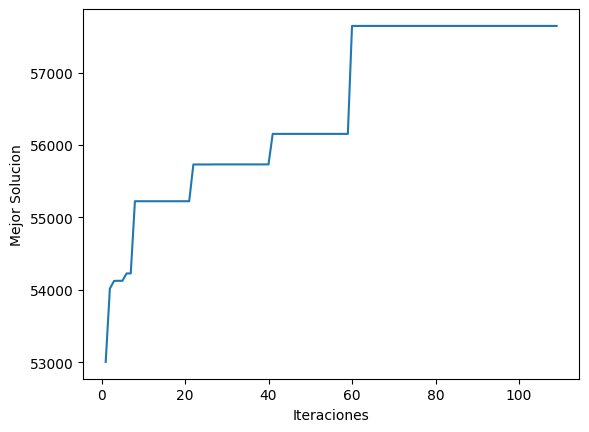

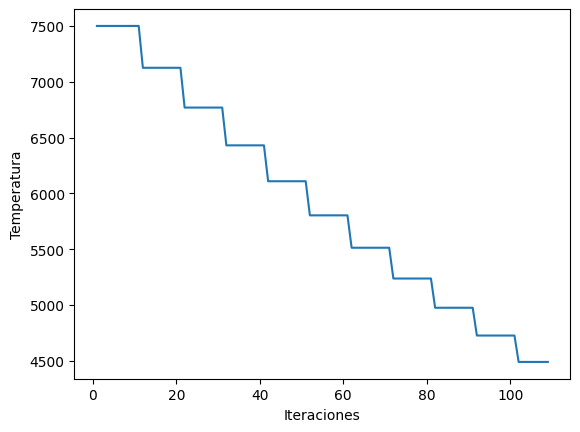

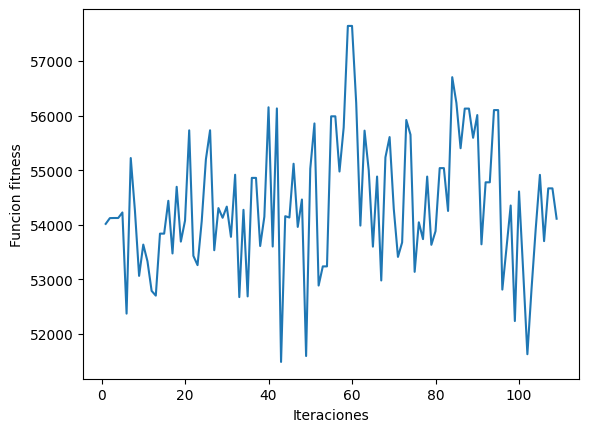

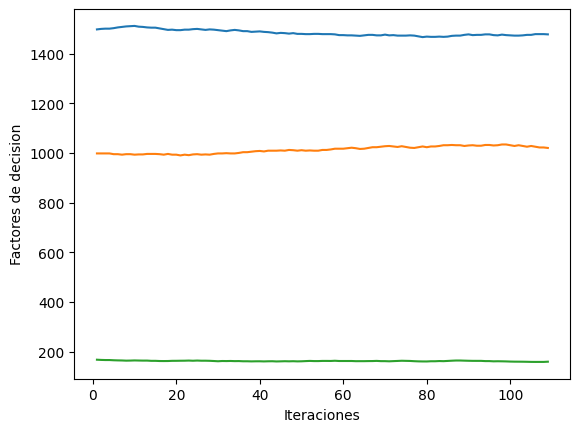

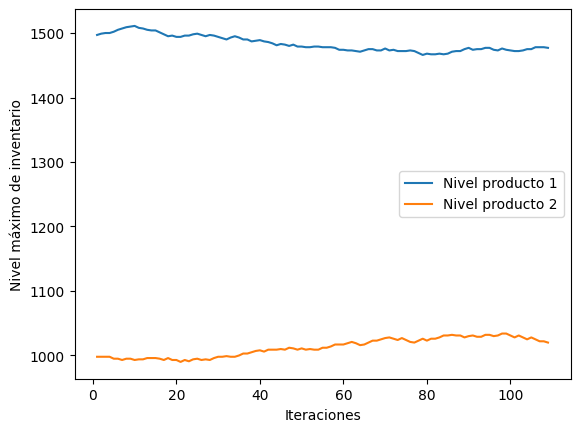

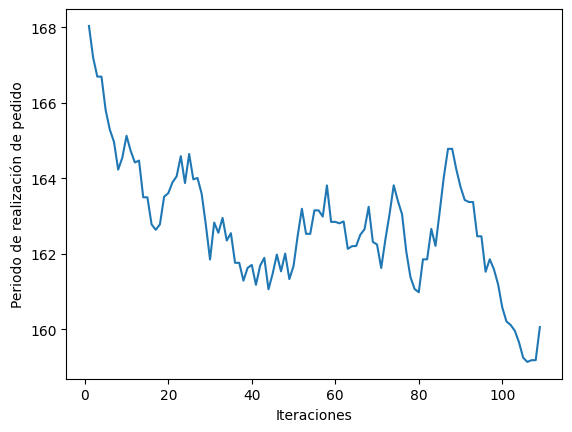

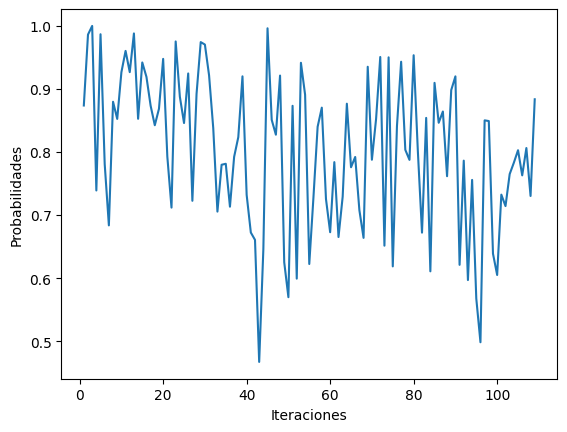

{'periodicidad': 162.8486175373323,
 'nivel_1': 1474,
 'nivel_2': 1017,
 'benef': 57644.060379780705}

In [49]:
initial_state = {'periodicidad': 168 ,  
                      'nivel_1': 1500,
                      'nivel_2': 1000 }

recocido_simulado(initial_state)

In [24]:
initial_state = {'periodicidad':168 ,  
                      'nivel_1': 1500,
                      'nivel_2': 1000 }
buscando_temperatura(8000, initial_state)

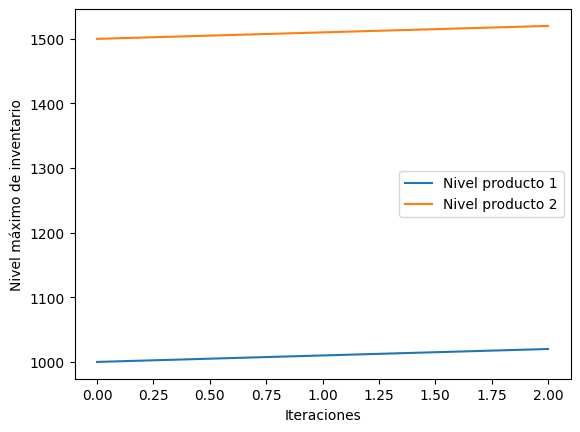

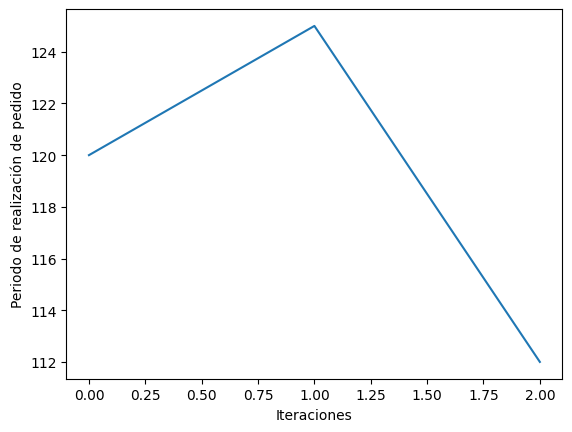

In [47]:
iteraciones=3
lista_niv_1 = [1000,1010,1020]
lista_niv_2 = [1500,1510,1520]
lista_periodo = [120, 125, 112]

grafica3('Iteraciones','Factores de decision',range(iteraciones),lista_niv_1,lista_niv_2,lista_periodo)